<a href="https://colab.research.google.com/github/SatyamRastogiD/Complete-ML-Projects/blob/main/End_to_End_Regression_Pipeline_Using_ScikitLearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of Burn Area using Meteorological Data

# Loading Libraries

In [5]:
#support python 2&3
from __future__ import division, print_function, unicode_literals

#common imports
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#make notebook's output stable across runs
np.random.seed(42)

#Pretty Figures
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

#Ignore useless warnings
import warnings
warnings.filterwarnings(action='ignore',message='^internal gelsd')
pd.options.mode.chained_assignment = None

In [9]:
# Any results you write to the current directory are saved as output
print(os.listdir("/content"))

['.config', 'forestfires.csv', 'sample_data']


# Laoding Data

In [10]:
# function to load data
fire = pd.read_csv("/content/forestfires.csv")
fire.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


the dataset doesn't have any missing values, so I am randomly removing some data points from FFMC attribute to showcase how to handle missing data problems

In [11]:
fire.FFMC[np.random.choice(fire.index,15)] = np.nan
fire.info() #now we have 15 missing values for attribute FFMC

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    502 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Data Exploration

In [12]:
fire.describe() #some attributes skewed to the right(mean>median) some to the left(mean<median)

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,502.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.653586,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.499615,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [13]:
#let's name the categorical and numeical attributes 
categorical_attributes = list(fire.select_dtypes(include=['object']).columns)
numerical_attributes = list(fire.select_dtypes(include=['float64', 'int64']).columns)
print('categorical_attributes:', categorical_attributes)
print('numerical_attributes:', numerical_attributes)

categorical_attributes: ['month', 'day']
numerical_attributes: ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']


In [14]:
#Here we face an uniqe issue where a few months have only 1 or 2 data points. I chose to get rid of these so that the glm models
#can handle the tests properly. Let me know how you would have hanlded.
print('months', fire.month.value_counts(), sep='\n')
print('\n')
print('days', fire.day.value_counts(), sep='\n')

months
aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
dec      9
apr      9
may      2
jan      2
nov      1
Name: month, dtype: int64


days
sun    95
fri    85
sat    84
mon    74
tue    64
thu    61
wed    54
Name: day, dtype: int64


In [15]:
months_to_remove = ['nov','jan','may']
forest_fire = fire.drop(fire[fire.month.isin(months_to_remove)].index ,axis=0)
forest_fire.month.value_counts()

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
dec      9
apr      9
Name: month, dtype: int64

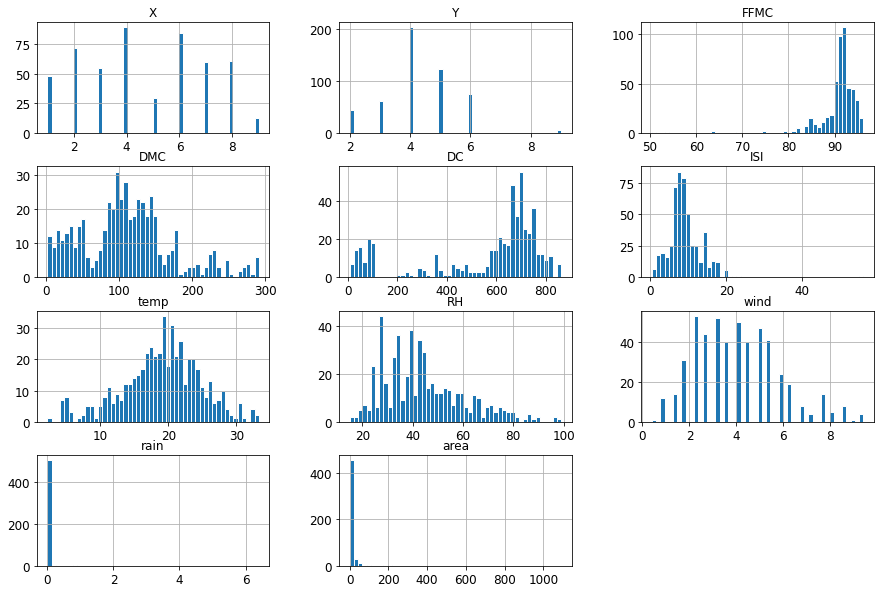

In [16]:
#visualizing distributions 
forest_fire.hist(bins=50, figsize=(15,10), ec='w')
plt.show()
#target-area-is heavily skewed, we have extreme outliers.

Text(800, 100, 'max: 1090.84')

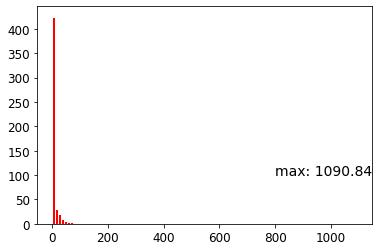

In [17]:
plt.hist(forest_fire.area, ec='w', bins=100, color='red')
plt.text(800,100, 'max: '+str(forest_fire.area.max()), color='black', fontsize=14)
#Burnt area attribute ranges from 0 to 1091.

In [18]:
#Grouping the the burnt area to get a better understanding
forest_fire['area_cat'] = pd.cut(forest_fire['area'], bins=[0,5, 10, 50, 100, 1100], include_lowest=True, 
                                 labels=['0-5', '5-10', '10-50', '50-100', '>100'])
forest_fire.area_cat.value_counts()

0-5       362
10-50      70
5-10       56
50-100     13
>100       11
Name: area_cat, dtype: int64

In [19]:
#Interquartile range
Q1 = forest_fire.area.quantile(.25)
Q3 = forest_fire.area.quantile(.75)
IQR = 1.5*(Q3-Q1)
IQR

9.85875

In [20]:
#we are loosing quite a number of data points in already a small data set if we remove all outliers
forest_fire.query('(@Q1 - 1.5 * @IQR) <= area <= (@Q3 + 1.5 * @IQR)').area_cat.value_counts(sort=False)

0-5       362
5-10       56
10-50      37
50-100      0
>100        0
Name: area_cat, dtype: int64

I chose to remove any area greater than 100. You could do it differently, maybe with log transformations or simply removing every outlier example. It all depends how you state your problem. For me it is a matter of showcasing several tricks of Scikit-Learn, but I would have gone for a log-log model otherwise. Maybe in part2, where I will do a Regression framework using TensorFlow in eager.

In [21]:
#remove outliers
forest_fire.drop(forest_fire[forest_fire.area>100].index,axis=0, inplace=True)
forest_fire.area_cat.value_counts()

0-5       362
10-50      70
5-10       56
50-100     13
>100        0
Name: area_cat, dtype: int64

# Assumptions

Assumption1- Temperature might be a great indicator of wildfires and it might be the case that high temperature may lead to more area burnt.

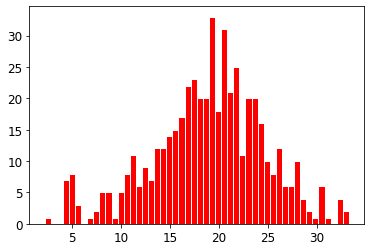

In [24]:
#Let's understand what temp ranges we have here.
plt.hist(forest_fire.temp, ec='w', bins=50, color='red')
plt.show()

In [25]:
forest_fire['temp_bins'] = pd.cut(forest_fire.temp, bins=[0, 15, 20, 25, 40], include_lowest=True, 
                                 labels=['0-15', '15-20', '20-25', '>25'])
forest_fire.temp_bins.value_counts(sort=False)
#so we have from very cold 0-15 degrees to hot >25 degree.

0-15     109
15-20    167
20-25    163
>25       62
Name: temp_bins, dtype: int64

As, I have assumed temp is a critical indicator, to have a golden test dataset I would prefer that both train and test has equally distributed temperature conditions. Stratified shuffle split will help us maintain the required strata compositions here. My strata set is temperature categories I have created above. Do note while creating groups make sure that all the groups are well represented

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(forest_fire.values, forest_fire.temp_bins.values):
    st_train_set = forest_fire.iloc[train_index]
    st_test_set = forest_fire.iloc[test_index]

Once you create the test data remember to not touch it until you finalize your model. Any exploration of test data would result in a biased perspective that might not generalize well to new data once the system is live.

In [29]:
#this works like magic.
print(st_test_set.temp_bins.value_counts(sort=False)/len(st_test_set), sep='\n')
print(forest_fire.temp_bins.value_counts(sort=False)/len(forest_fire), sep='\n')

0-15     0.217822
15-20    0.336634
20-25    0.326733
>25      0.118812
Name: temp_bins, dtype: float64
0-15     0.217565
15-20    0.333333
20-25    0.325349
>25      0.123752
Name: temp_bins, dtype: float64


In [30]:
#now lets drop the area and temp categories 
for _ in (st_train_set, st_test_set):
    _.drop(['area_cat','temp_bins'], axis=1, inplace=True)
    
forest_fire = st_train_set.copy()
forest_fire.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
359,1,4,sep,fri,92.5,122.0,789.7,10.2,21.1,39,2.2,0.0,8.12
314,4,4,sep,wed,92.6,115.4,777.1,8.8,19.7,41,1.8,0.0,1.58
203,8,6,oct,wed,91.4,37.9,673.8,5.2,20.2,37,2.7,0.0,13.70
319,5,4,sep,thu,92.8,119.0,783.5,7.5,21.6,28,6.3,0.0,4.41
51,4,3,aug,sun,90.2,99.6,631.2,6.3,21.5,34,2.2,0.0,0.00


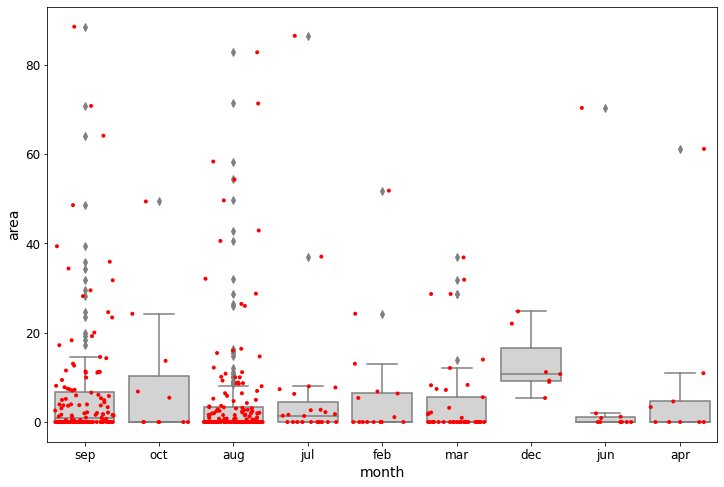

In [31]:
#December had a few incidents but all on the higher burnt area side. Is it becuase dry weather or because more tourists? 
ax = plt.figure(figsize=(12,8))
ax = sns.boxplot(x='month', y='area', data=forest_fire, color='lightgrey', )
ax = sns.stripplot(x='month', y='area', data=forest_fire, color='red', jitter=0.4, size=4)

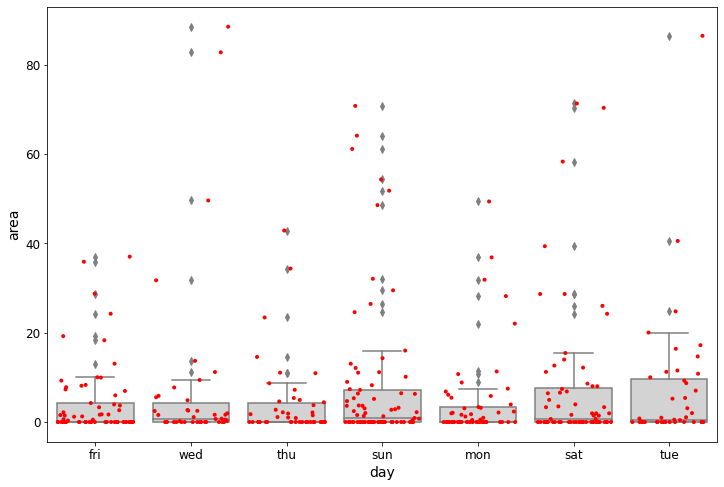

In [32]:
#There are more incidents on weekends - Friday/Sat/Sun, it might mean that campers vactioning might have caused/spotted fires.
ax = plt.figure(figsize=(12,8))
ax = sns.boxplot(x='day', y='area', data=forest_fire, color='lightgrey', )
ax = sns.stripplot(x='day', y='area', data=forest_fire, color='red', jitter=0.4, size=4)

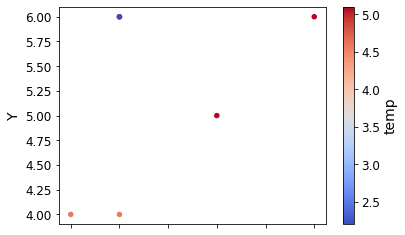

In [33]:
#I am checking the temparature distribution as per the forest cordinates during the month of december
#it looks like the temps are low, so it could be a combinaton of dry weather and human made fire. But as data scientists,
#we must make important discoveries to arrive at any conclusive evidence. Else the above statments are just my mind made 
#fantsies
forest_fire[forest_fire.month=='dec'].plot(kind='scatter', x='X', y='Y', c='temp', cmap=plt.get_cmap('coolwarm'), colorbar=True)
plt.show()

Spearman rank correlation is more robust to the effect of outliers than Pearson’s correlations coefficient. If you need to know why I will load a new kernel sometime. But do remember we are just checking linear correlations her

In [34]:
corr_matrix = forest_fire.corr(method='spearman')
corr_matrix

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
X,1.000000,0.481958,-0.070729,-0.082882,-0.097020,0.003760,-0.060757,0.081566,0.016699,0.106047,0.038364
Y,0.481958,1.000000,-0.027837,0.006697,-0.116588,-0.050865,-0.047194,0.075483,-0.056825,0.065329,0.062555
FFMC,-0.070729,-0.027837,1.000000,0.494726,0.229370,0.795014,0.594105,-0.347661,-0.030324,0.118104,0.018090
DMC,-0.082882,0.006697,0.494726,1.000000,0.562753,0.394178,0.468887,0.043702,-0.098967,0.166716,0.026109
DC,-0.097020,-0.116588,0.229370,0.562753,1.000000,0.082584,0.274941,0.050014,-0.157062,0.033104,0.036140
ISI,0.003760,-0.050865,0.795014,0.394178,0.082584,1.000000,0.406165,-0.171347,0.128069,0.133786,0.019129
temp,-0.060757,-0.047194,0.594105,0.468887,0.274941,0.406165,1.000000,-0.551008,-0.184548,0.056701,0.048286
RH,0.081566,0.075483,-0.347661,0.043702,0.050014,-0.171347,-0.551008,1.000000,0.100768,0.187838,-0.043599
wind,0.016699,-0.056825,-0.030324,-0.098967,-0.157062,0.128069,-0.184548,0.100768,1.000000,0.146433,0.049758
rain,0.106047,0.065329,0.118104,0.166716,0.033104,0.133786,0.056701,0.187838,0.146433,1.000000,-0.056283


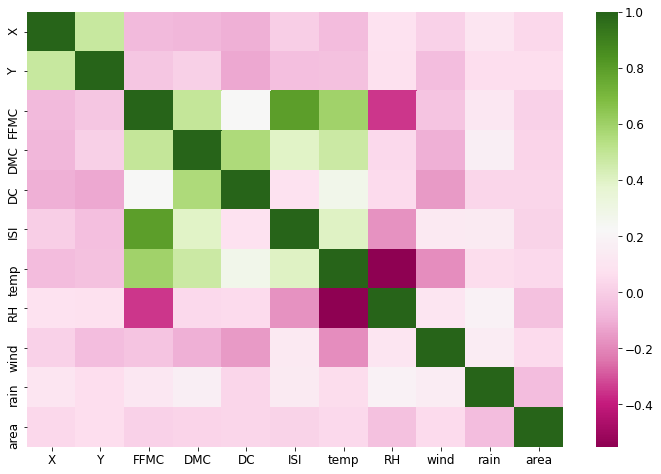

In [35]:
ax = plt.figure(figsize=(12,8))
ax = sns.heatmap(corr_matrix, cmap='PiYG')

In [36]:
#corrleation with area
corr_matrix.area.sort_values(ascending=False)

area    1.000000
Y       0.062555
wind    0.049758
temp    0.048286
X       0.038364
DC      0.036140
DMC     0.026109
ISI     0.019129
FFMC    0.018090
RH     -0.043599
rain   -0.056283
Name: area, dtype: float64

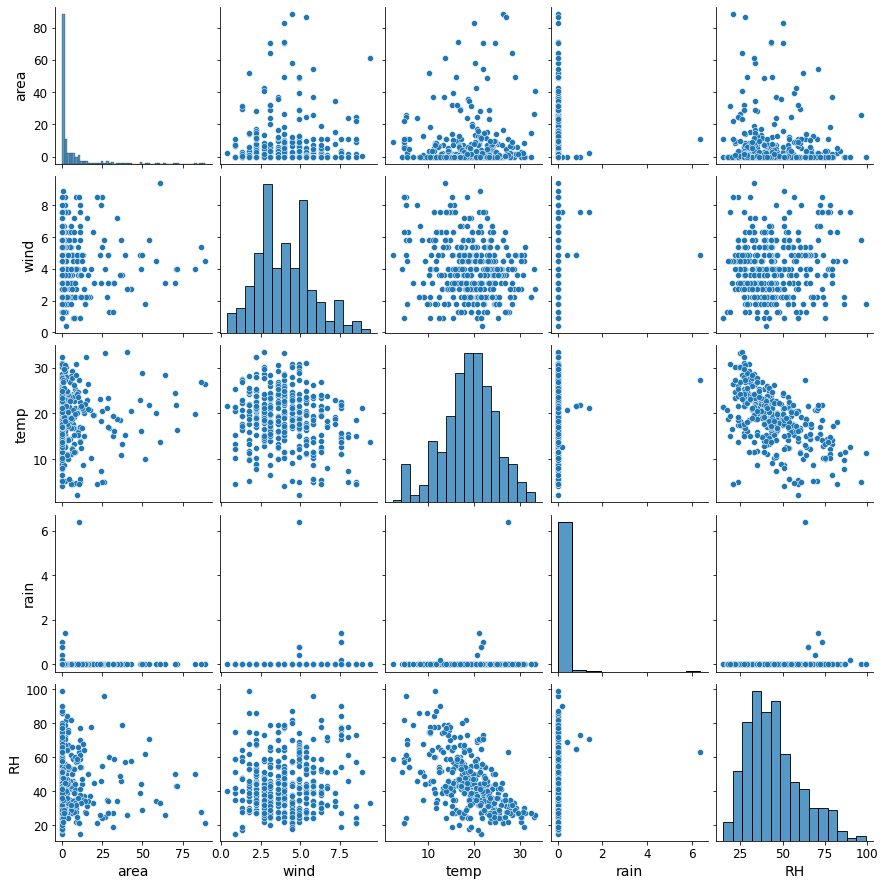

In [37]:
#visualizing relations of most related attributes
attributes = ['area', 'wind', 'temp', 'rain', 'RH']
sns.pairplot(forest_fire[attributes])
plt.show()

In [38]:
#create a fresh copy of train to preprocess
forest_fire = st_train_set.drop('area', axis=1)
forest_fire_labels = st_train_set.area.copy()

# Transformation

I chose to remove coordinates X & Y before model building. The reason being here we are building a model that will use weather conditions to determine the severity of a wildfire based on area burnt, so keeping X&Y locations of one forest does ‘t generalize well to others.
Now in the process of data prep, you might need to create or drop several columns. So, it's a good idea to automate the process. Below an example of what an Attribute/Feature deleter will look like.

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin

class AttributeDeleter(BaseEstimator, TransformerMixin):
    def __init__(self, delete=True):
        self.delete = delete
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return np.delete(X,[fire.columns.get_loc(i) for i in['X','Y','area']],axis=1)

With same reasoning, you need to do a lot of transformations depending on the task, so having a custom pipeline that helps you automate these tasks will simplify your deployment process in the end.
To handle missing data, I chose to fill them with median values of the attribute you can choose to do differently, or once you finalize your model you can do a hyperparameter tuning to find out which imputing strategy works best using a grid search. Imputing simply means what value are you going to put in place of null values.
I chose to create of dummies out of my categorical attributes, but you can do a low-level vector representation of them using embeddings. OneHotEncoder does that for me.
And lastly, we have data attributes in many different scales. So, it's always a good idea to either standardize or normalize the scales. Reason being many instances based and model based learning have a distance based cost function to minimize to get the best possible similarity or model fit parameters. Having a standardized scale helps us find the best possible parameters in an efficient way.

# Pipeline Creation

In [41]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

categorical_attributes = list(forest_fire.select_dtypes(include=['object']).columns)
numerical_attributes = list(forest_fire.select_dtypes(include=['float64', 'int64']).columns)

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('drop_attributes', AttributeDeleter()),
                         ('std_scaler', StandardScaler()),
                        ])
full_pipeline = ColumnTransformer([('num', num_pipeline, numerical_attributes),
                                   ('cat', OneHotEncoder(), categorical_attributes),
                                  ])

train = full_pipeline.fit_transform(forest_fire)
train_labels = forest_fire_labels
train.shape ,forest_fire.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  if __name__ == '__main__':


((400, 24), (400, 12))

Now we can finally start the model selection process where we try out bunch of different models. Choose some and fine tune them before finalizing one.

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(train, train_labels)

area_predictions = lin_reg.predict(train)
lin_mse = mean_squared_error(train_labels, area_predictions)
lin_rmse = np.sqrt(lin_mse)
print('linear_train_rmse', lin_rmse) #model might be underfitting

from sklearn.model_selection import cross_val_score
scores = cross_val_score(lin_reg, train, train_labels, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-scores)

def explain_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
 
explain_scores(lin_rmse_scores)

linear_train_rmse 13.408351802213172
Scores: [16.01181085 11.85147634 13.52834459 17.82237591 11.01185707 16.30916709
 12.44789601 12.50009332 20.8719534   9.47630378]
Mean: 14.183127836139983
Standard deviation: 3.313136940693585


In [43]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(train, train_labels)

area_predictions = tree_reg.predict(train)
tree_mse = mean_squared_error(train_labels, area_predictions)
tree_rmse = np.sqrt(tree_mse)
print('tree_train_rmse', tree_rmse) #model obviously overfitting

scores = cross_val_score(tree_reg, train, train_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)
explain_scores(tree_rmse_scores)

tree_train_rmse 3.7388655197800307
Scores: [21.90990799 26.70966732 18.95440292 19.70253462 17.07366913 22.03832196
 17.49653641 20.64671458 20.1917216  21.55456628]
Mean: 20.627804281422478
Standard deviation: 2.6031698518015642


In [44]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()
rf_reg.fit(train, train_labels)

area_predictions = rf_reg.predict(train)
rf_mse = mean_squared_error(train_labels, area_predictions)
rf_rmse = np.sqrt(rf_mse)
print('rf_train_rmse', rf_rmse) #model is overfitting 

scores = cross_val_score(rf_reg, train, train_labels, scoring='neg_mean_squared_error', cv=10)
rf_rmse_scores = np.sqrt(-scores)
explain_scores(rf_rmse_scores)

rf_train_rmse 6.4136011361797465
Scores: [15.1873516  17.28923062 13.67626227 17.81369064 11.57408179 17.7953606
 12.91392765 13.39700001 21.38356317 13.53484601]
Mean: 15.456531437672428
Standard deviation: 2.8675673081866337


In [45]:
from sklearn.svm import SVR

svm_reg = SVR(kernel='linear')
svm_reg.fit(train, train_labels)

area_predictions = svm_reg.predict(train)
svm_mse = mean_squared_error(train_labels, area_predictions)
svm_rmse = np.sqrt(svm_mse)
print('svm_train_rmse', svm_rmse) #svm is generalizing well to crossvalidation set

scores = cross_val_score(svm_reg, train, train_labels, scoring='neg_mean_squared_error', cv=10)
svm_rmse_scores = np.sqrt(-scores)
explain_scores(svm_rmse_scores)

svm_train_rmse 14.733283759783474
Scores: [16.27139224 11.47787044 13.33049909 18.73071215 12.32326765 17.80343673
 11.84191105 11.59399797 21.52286507  8.19784989]
Mean: 14.309380229983105
Standard deviation: 3.8906717758894844


In [46]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor()
knn_reg.fit(train, train_labels)

area_predictions = knn_reg.predict(train)
knn_mse = mean_squared_error(train_labels, area_predictions)
knn_rmse = np.sqrt(knn_mse)
print('knn_train_rmse', knn_rmse) #overfiiting

scores = cross_val_score(knn_reg, train, train_labels, scoring='neg_mean_squared_error', cv=10)
knn_rmse_scores = np.sqrt(-scores)
explain_scores(knn_rmse_scores)

knn_train_rmse 12.264732235560627
Scores: [15.44431282 13.26958344 14.2681095  18.89717775 12.73927185 17.07379813
 13.14335727 12.84071475 21.89010291 11.89887815]
Mean: 15.146530657284037
Standard deviation: 3.0547068841305847


In [47]:
#lets improve the models with hyperparameter tuning

from sklearn.model_selection import GridSearchCV

param_grid = [{'bootstrap':[False,True],'n_estimators':[75,100,125,150,200], 'max_features':[1,2,4,6]}]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(train, train_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [48]:
grid_search.best_params_ 

{'bootstrap': True, 'max_features': 1, 'n_estimators': 200}

In [49]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [50]:
feature_importances = grid_search.best_estimator_.feature_importances_
attributes = numerical_attributes + list(full_pipeline.named_transformers_.cat.categories_[0]) +\
             list(full_pipeline.named_transformers_.cat.categories_[1])
    
sorted(zip(feature_importances, attributes), reverse=True)

[(0.16054064043802355, 'DC'),
 (0.14468619375614225, 'ISI'),
 (0.12207639780404937, 'temp'),
 (0.1059706349923087, 'Y'),
 (0.10563673965453989, 'FFMC'),
 (0.09401546558080502, 'X'),
 (0.09127444061684983, 'DMC'),
 (0.020704874788540554, 'thu'),
 (0.020625854757968732, 'mon'),
 (0.018142428650529403, 'rain'),
 (0.01570279979716167, 'fri'),
 (0.013171868775175401, 'sun'),
 (0.012641126459811356, 'dec'),
 (0.01193157947293523, 'feb'),
 (0.010497385090699227, 'oct'),
 (0.009959536224159795, 'mar'),
 (0.008767664590885798, 'sep'),
 (0.008759702070206425, 'sat'),
 (0.006498313801314334, 'jul'),
 (0.005203041262257841, 'wind'),
 (0.004499781663656073, 'jun'),
 (0.0032604524900602867, 'aug'),
 (0.003193543035794565, 'apr'),
 (0.002239534226124663, 'RH')]

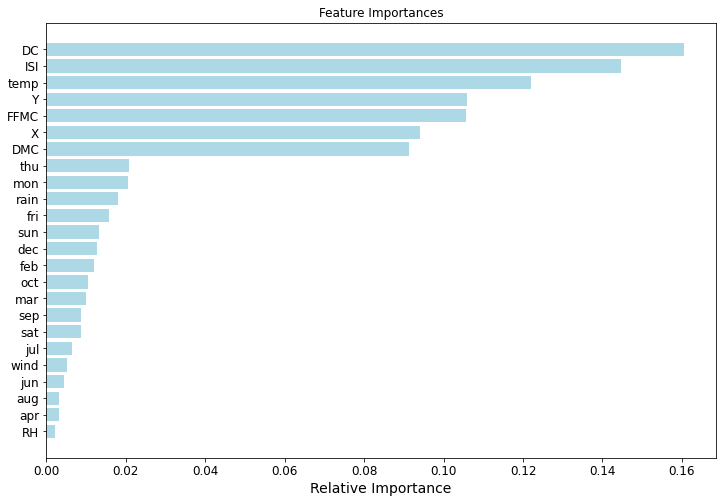

In [51]:
indices = np.argsort(feature_importances)
plt.figure(figsize=(12,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='lightblue', align='center')
plt.yticks(range(len(indices)), [attributes[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [52]:
#lets try with RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {'n_estimators': randint(low=10, high=250),
              'max_features': randint(low=1, high=24),
             }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_dist, n_iter=40, cv=5, scoring='neg_mean_squared_error', random_state=42)

rnd_search.fit(train, train_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [53]:
rnd_search.best_params_

{'max_features': 4, 'n_estimators': 98}

In [54]:
np.sqrt(-rnd_search.best_score_), np.sqrt(-grid_search.best_score_) #both have very similar scores even though they came up with 
#different best parameters. which one to use, I leave to you explain

(14.899327797269214, 14.803009140608504)

In [55]:
#tuning svr

param_grid = [{'kernel': ['linear'], 'C':[0.5,1,5,10,30]},
              {'kernel':['rbf'], 'C':[5,10,15,20], 'gamma':[0.5,1.0,1.5,2.0]},
             ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=4)
grid_search.fit(train,train_labels)

negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 105 out of 105 | elapsed:    5.1s finished


14.279281809880544

In [56]:
grid_search.best_params_

{'C': 10, 'gamma': 1.5, 'kernel': 'rbf'}

In [57]:
from scipy.stats import expon, reciprocal

param_dist = {'kernel':['linear','rbf'],
                  'C':reciprocal(1,100),
                  'gamma':expon(scale=1.0)}
svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_dist, n_iter=100, cv=5,
                               scoring='neg_mean_squared_error', verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(train, train_labels)

negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  92 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done 332 tasks      | elapsed:   15.4s
[Parallel(n_jobs=4)]: Done 493 out of 500 | elapsed:   27.7s remaining:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   28.6s finished


14.287286738686516

In [58]:
rnd_search.best_params_ #randomized search is able to find better parameters for rbf kernel in same number of iterations

{'C': 10.414253710293567, 'gamma': 1.0115156153275293, 'kernel': 'rbf'}

At times it is a good idea to use only your best features in the model, but it is context dependent. Below sample code helps you add another transformer to your pipeline that chooses the best feature based on an estimated feature importance


In [59]:
def indices_top_features(impotance, top):
    return np.sort(np.argpartition(np.array(impotance), -top)[-top:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importnaces, top):
        self.feature_importnaces = feature_importances
        self.top = top
    def fit(self, X, y=None):
        self.feature_indcies_ = indices_top_features(self.feature_importnaces, self.top)
        return self
    def transform(self,X):
        return X[:, self.feature_indcies_]

In [60]:
data_prep_feature_seletion_pipe = Pipeline([('prep', full_pipeline),
                                            ('fe_select', TopFeatureSelector(feature_importances,5)) #here am choosing top 5 features you can choose others depending on 
                                           ])                                                        #on what you want to keep 

In [61]:
train_fe_selected = data_prep_feature_seletion_pipe.fit_transform(forest_fire)
train_fe_selected.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  if __name__ == '__main__':


(400, 5)

In [62]:
#now let's try knn with these reduced dimensions 

knn_reg = KNeighborsRegressor()
knn_reg.fit(train_fe_selected, train_labels)

area_predictions = knn_reg.predict(train_fe_selected)
knn_mse = mean_squared_error(train_labels, area_predictions)
knn_rmse = np.sqrt(knn_mse)
print('knn_train_rmse', knn_rmse) #knn is generalizing well to crossvalidation set

scores = cross_val_score(knn_reg, train_fe_selected, train_labels, scoring='neg_mean_squared_error', cv=10)
knn_rmse_scores = np.sqrt(-scores)
explain_scores(knn_rmse_scores)

knn_train_rmse 12.410643353186812
Scores: [15.82385426 13.66648182 14.32809107 19.03754417 12.9068144  17.30360238
 13.26014549 10.96969598 21.70251846  9.79899367]
Mean: 14.879774169263836
Standard deviation: 3.464077990130809


In [63]:
#lets tune KNN 
param_grid = {'weights': ['uniform', 'distance'], 'n_neighbors': list(range(1,36,5))}

knn_reg= KNeighborsRegressor()
knn_grid_search = GridSearchCV(knn_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=4)
knn_grid_search.fit(train_fe_selected,train_labels)

knn_negative_mse = knn_grid_search.best_score_
knn_rmse = np.sqrt(-knn_negative_mse)
knn_rmse

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.5s finished


14.12515060556197

In [64]:
#and for final model I want to try GBM
from xgboost import XGBRegressor

xgb_reg = XGBRegressor()
xgb_reg.fit(train_fe_selected, train_labels)

area_predictions = xgb_reg.predict(train_fe_selected)
xgb_mse = mean_squared_error(train_labels, area_predictions)
xgb_rmse = np.sqrt(xgb_mse)
print('xgb_train_rmse', xgb_rmse) #overfitting

scores = cross_val_score(xgb_reg, train_fe_selected, train_labels, scoring='neg_mean_squared_error', cv=10)
xgb_rmse_scores = np.sqrt(-scores)
explain_scores(xgb_rmse_scores)

[13:39:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgb_train_rmse 9.510023888294025
[13:39:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:39:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:39:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:39:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:39:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:39:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:39:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear

In [65]:
param_grid = {'objective':['reg:linear'],
              'learning_rate': [0.02,0.03,0.04], 
              'max_depth': [1,2],
              'min_child_weight': [2,3,4],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.2,0.3,0.4],
              'n_estimators': [50,60,70,100]}

xgb_reg = XGBRegressor()

xgb_grid_search = GridSearchCV(xgb_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=4)
xgb_grid_search.fit(train_fe_selected,train_labels)

xgb_negative_mse = grid_search.best_score_
xgb_rmse = np.sqrt(-xgb_negative_mse)
xgb_rmse

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 728 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 1080 out of 1080 | elapsed:   11.9s finished


14.279281809880544

In [66]:
xgb_grid_search.best_params_

{'colsample_bytree': 0.2,
 'learning_rate': 0.03,
 'max_depth': 1,
 'min_child_weight': 2,
 'n_estimators': 70,
 'objective': 'reg:linear',
 'silent': 1,
 'subsample': 0.8}

In [67]:
final_model = knn_grid_search.best_estimator_

X_test = st_test_set.drop(['area'], axis=1)
y_test = st_test_set['area'].copy()

X_test_prepared = data_prep_feature_seletion_pipe.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  if __name__ == '__main__':


13.5845575382228

Let's say, I determined to deploy XGB model. I will add a predictor to my previously defined Pipeline as the last element., which will take care of the entire process from preparing the data to predicting area

In [68]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, 5)),
    ('final_model', XGBRegressor(**xgb_grid_search.best_params_))
])

In [69]:
prepare_select_and_predict_pipeline.fit(forest_fire,forest_fire_labels)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  if __name__ == '__main__':


Pipeline(memory=None,
         steps=[('preparation',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                              

In [70]:
final_predictions = prepare_select_and_predict_pipeline.predict(X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  if __name__ == '__main__':


An example showing a small use case. Let's assume some_data here are the new data that our system will predict for.

In [73]:
some_data = forest_fire[:4]
some_labels = forest_fire_labels[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [4.5554733 4.5554733 4.705267  5.3368034]
Labels:		 [8.12, 1.58, 13.7, 4.41]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  if __name__ == '__main__':


In [74]:
#Confidence Interval of our Predictions will help us better understand the ouput of our model
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions-y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([ 4.7743105, 18.7834699])